In [ ]:
settings = {
    "xsrf_cookies": False,
}

In this notebook we explore using random forest to determine activity values of molecules (using regression) and predicting an active/inactive molecule (using classification).  First we load the fingerprints from RDkit.

In [1]:
import pandas as pd
import itertools
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_pickle('../processed_data/combined_dataset.pkl')
N=len(data.loc[data['target'] == 'TMPRSS2']) #number of compounds tested against TMPRSS2 itself
fp_dark=np.load('../dumps/deprecated/DarkChemicalMatter_morgan_fingerprints.npz')
fp_dark=fp_dark['fps']

We have two sets of activity values since not all compound assays were performed against TMPRSS2 (the protease of interest in this study).  Thus, some compounds' activity values have to be scaled via a correlation of the protease they were originally purposed for, against TMPRSS2.  We save the binary values of whether a compound was deemed active/inactive as "activity", and the numeric activity value as "ac_merged".  Also we note if the values are taken from the "scaled" dataset.  Ac values are converted to negative log10.  Finally we convert everything to numpy array to input into random forest.

In [2]:
#convert to array
#using merged data from pickle
datalabels=list(data['target'])
fps_merged=np.stack(data['morgan_fingerprint'])
ac_merged_scaled=np.asarray(data['acvalue_scaled_to_tmprss2'])
cids=list(data['cid'])
act_list=list(data['activity_target'])
activity_scaled=[]
activity=[]
for i in range(len(act_list)):
    if act_list[i] == 'Active':
        activity.append(1)
    else:
        activity.append(0)
    if ac_merged_scaled[i]>0:
        if act_list[i] == 'Active':
            activity_scaled.append(1)
        else:
            activity_scaled.append(0)
#alternatively
ac_merged=np.asarray(data['acvalue_target'])
#keep only the positive vals in ac_merged
fps_merged_scaled=fps_merged[ac_merged_scaled>0]
cids_scaled=[cid for i, cid in enumerate(cids) if ac_merged_scaled[i]>0]
ac_merged_scaled=ac_merged[ac_merged_scaled>0]

activity=np.array(activity)
ac_merged=np.array(ac_merged)
ac_merged=-np.log10(ac_merged)
activity_scaled=np.array(activity_scaled)
ac_merged_scaled=np.array(ac_merged_scaled)
ac_merged_scaled=-np.log10(ac_merged_scaled)

/Users/schu3/.conda/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Users/schu3/.conda/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


Now we split the training and the test data.  To test how well the random forest works, we split the compounds with known TMPRSS2 activity (that is, their recorded ac value is from an assay against TMPRSS2) between the training and test sets.  Here I've used a 2/3 training 1/3 test split, which can be changed by changing variable "n_test".  The indices assigned by the split is randomly shuffled each time the code is run.

In [8]:
#split train and test 
#split the tmprss2 active compounds into training and test
import random
s=np.arange(N)
random.shuffle(s)
n_test=round(N/3) #percentage to withold for testing
cut=n_test
test=s[0:cut]
train=s[cut::]

Here we generate training and test sets for the classifier, which incorporates the "dark chemical matter" which is known to be inactive.  We split the dark chemical matter evenly between the test and training sets.  You can skip the following code block if not running the classifier.  The purpose of the classifier is to do a preliminary "filtering" of active/inactive molecules for the regressor.

In [7]:
s=np.arange(len(fp_dark))
random.shuffle(s)
cut=round(len(fp_dark)/2)
test_dark=s[0:cut]
train_dark=s[cut::]
X_test=np.concatenate((fps_merged_scaled[test], fp_dark[test_dark]))
X_train=np.concatenate((fps_merged_scaled[train], fps_merged_scaled[92::], fp_dark[train_dark]))
y_train=np.concatenate((activity_scaled[train], activity_scaled[92::], np.zeros([len(train_dark)])))
y2_train=np.concatenate((ac_merged_scaled[train], ac_merged_scaled[92::], np.zeros([len(train_dark)])))
y_test=np.concatenate((activity_scaled[test], np.zeros([len(test_dark)])))
y2_test=np.concatenate((ac_merged_scaled[test],np.zeros([len(test_dark)])))

X_test_u=np.concatenate((fps_merged[test], fp_dark[test_dark]))
X_train_u=np.concatenate((fps_merged[train], fps_merged[92::], fp_dark[train_dark]))
y_train_u=np.concatenate((activity[train], activity[92::], np.zeros([len(train_dark)])))
y2_train_u=np.concatenate((ac_merged[train], ac_merged[92::], np.zeros([len(train_dark)])))
y_test_u=np.concatenate((activity[test], np.zeros([len(test_dark)])))
y2_test_u=np.concatenate((ac_merged[test],np.zeros([len(test_dark)])))
#generate big training set
X_train_all=np.concatenate((fps_merged_scaled, fp_dark))
y2_train_all=np.concatenate((ac_merged_scaled, np.zeros([len(fp_dark)])))
y_train_all=np.concatenate((activity_scaled, np.zeros([len(fp_dark)])))

Here we run the classifier for the test case (where our test set has some compounds with known TMPRSS2 activity).

In [ ]:
###YOU CAN SKIP THIS STEP IF NOT RUNNING THE CLASSIFIER###
rf=RandomForestClassifier(verbose=2, n_estimators=100, random_state=111)
rf.fit(np.asarray(X_train), np.asarray(y_train))

In [ ]:
y_pred=rf.predict(X_test)
print(rf.score(X_test, y_test))

and we see how well it does in terms of precision and recall.

In [ ]:
#get the index of the features (of RDkit fingerprint) that were important
importances = rf.feature_importances_
featurenums = np.array([str(x).zfill(2) for x in range(len(importances))])
indices = np.argsort(importances)[::-1][0:25]#get the 25 most important features
plt.title('Feature Importances (train set)')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.ylabel('Relative Importance')
plt.xticks(range(len(indices)), featurenums[indices], rotation=90)
plt.show()
#output metrics
print(classification_report(y_test, y_pred))

REGRESSION
Here we again take the same random splits of training and test set (set by the variable "n_test") as a proportion of compounds in the ground truth TMPSSR2 assay data, but we don't add the dark data, which can distort the results of regression. We train both the "scaled" version with scaled data and the version with unscaled data.

In [16]:
X_test_reg=fps_merged[test]
X_train_reg=np.concatenate((fps_merged[train], fps_merged[92::]))
y2_train_reg=np.concatenate((ac_merged[train], ac_merged[92::]))
y2_test_reg=ac_merged[test]
nan_array=np.isnan(y2_train_reg)
X_train_reg=X_train_reg[~nan_array]
y2_train_reg=y2_train_reg[~nan_array]
#and generate for scaled arrays
X_train_reg_scaled=np.concatenate((fps_merged_scaled[train], fps_merged_scaled[92::]))
y2_train_reg_scaled=np.concatenate((ac_merged_scaled[train], ac_merged_scaled[92::]))

rg_pos_only=RandomForestRegressor(verbose=2, n_estimators=100, random_state=111)
rg_pos_only_scaled=RandomForestRegressor(verbose=2, n_estimators=100, random_state=111)
rg_pos_only.fit(np.asarray(X_train_reg), np.asarray(y2_train_reg))
rg_pos_only_scaled.fit(np.asarray(X_train_reg_scaled), np.asarray(y2_train_reg_scaled))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

Examine mean squared error (MSE) for both scaled and unscaled dataset.

In [17]:
from sklearn.metrics import mean_squared_error
#the test set only contains unscaled values from TMPRSS2 assay so its the same for both classifier and regressor.

#scaled data, regression on positives
y_pred_regr_pos=rg_pos_only.predict(X_test_reg)
print(mean_squared_error(y2_test_reg, y_pred_regr_pos))

#unscaled data, regression on positives
y_pred_regr_scaled_pos=rg_pos_only_scaled.predict(X_test_reg)
print(mean_squared_error(y2_test_reg, y_pred_regr_scaled_pos))

0.4003748186250653
0.49285934164176015


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Here we select the 25 most important features from the morgan fingerprints.

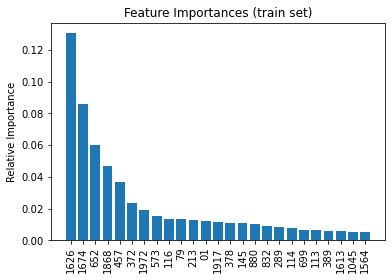

In [18]:
importances = rg_pos_only_scaled.feature_importances_
featurenums = np.array([str(x).zfill(2) for x in range(len(importances))])
indices = np.argsort(importances)[::-1][0:25]#get the 25 most important features
plt.title('Feature Importances (train set)')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.ylabel('Relative Importance')
plt.xticks(range(len(indices)), featurenums[indices], rotation=90)
plt.show()

Then we plot the predicted values from regressing both unscaled and "scaled" data (in red) and the actual activity values from the assays (in blue).  Note that these are plotted with y-axis in negative log10 scale so a higher number = lower activity value.

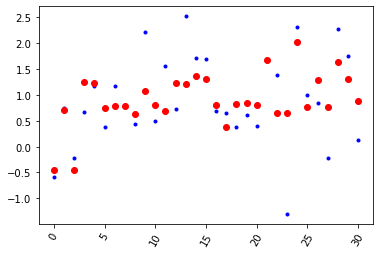

In [19]:
#plots, first is for unscaled regression
plt.plot(y2_test_reg, 'b.', label = 'actual')
# Plot the predicted values
plt.plot(y_pred_regr_pos, 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 

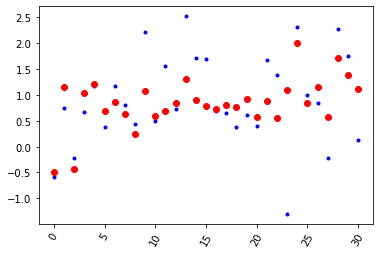

In [20]:
#second is for scaled regression
plt.plot(y2_test_reg, 'b.', label = 'actual')
# Plot the predicted values
plt.plot(y_pred_regr_scaled_pos, 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 

When we're satisfied with tuning the random forest regressor, we can build the regressor with all of the data combined to run on an unknown screening set.  First we load the screening dataset

In [45]:
screening_fp=pd.read_pickle('../dumps/screening_data_processed.pkl')
screening_fp.head()
molnames_all=list(screening_fp['name'])
molnames_all=np.asarray(molnames_all)
screening=np.stack(screening_fp['morgan_fingerprint'])
sources=list(screening_fp['source'])

Then build the regressor based on the scaled dataset

In [23]:
rg_all=RandomForestRegressor(verbose=2, n_estimators=100, random_state=111)
rg_all.fit(np.asarray(fps_merged_scaled), np.asarray(ac_merged_scaled))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

In [35]:
predicted_activity=rg_all.predict(screening)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Predict the activities from screening library and plot the top 20 hits.  We also plot the predicted activity values color coded by screening library.

['Nafamostat' 'Patamostat' 'Camostat' 'RWJ-56423' 'RWJ-51084'
 '1-[(4S)-4-amino-5-(1,3-benzothiazol-2-yl)-5-oxopentyl]guanidine'
 'RWJ-58643' 'Sepimostat mesilate' 'Camostat' 'camostat-mesilate'
 'camostat-mesilate' 'nafamostat' 'nafamostat' 'nafamostat' 'Nafamostat'
 'TG-100801' 'TG-100801' 'estradiol-benzoate' 'Ono-3307' 'Aminaphthone']
[2.9189837  2.85395638 2.73682988 2.49405424 2.4840624  1.95623934
 1.8861844  1.75733139 1.74174302 1.74174302 1.74174302 1.72920165
 1.72920165 1.72920165 1.72920165 1.59493182 1.59493182 1.52843836
 1.52123018 1.50347266]


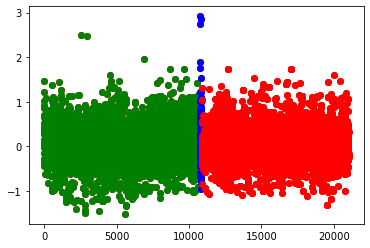

In [43]:
#plot and print the top 20 hits
#plotted values are in -log10 form (higher is better)
for i, pa in enumerate(predicted_activity):
    if sources[i] == 'drugbank':
        plt.plot(i, pa, 'go', label='drugbank')
    elif sources[i] == 'broad':
        plt.plot(i, pa, 'ro', label='broad')
    else:
        plt.plot(i, pa, 'bo', label='reframe')
indices=np.argpartition(predicted_activity, -20)[-20:]
print(molnames_all[indices][np.argsort(predicted_activity[indices])][::-1])
print(np.sort(predicted_activity[indices])[::-1])